Import Libraries and Packages

In [1]:
# import relevant packages
from utils import * # for project-specific custom functions
from policy import * # for policy functions
from plot_utils import * # for plotting functions

import os # for directories
import random
import math
from itertools import permutations

from pathlib import Path # path functions
from scipy.spatial.transform import Rotation as R # to convert between Euler angles and Quaternions
from IPython.display import clear_output, display

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

Setup directories, paths and variables

In [2]:
cwd = os.getcwd() # Current working directory
dataDir = os.path.join(Path(cwd).parents[1], "Data\MultiTargetHerdingExperiment") #Directory of all sessions
colors = ['r', 'g', 'b']  #colors to plot the target agents in

firstTrial = 1+6
lastTrial = 18+6+1
numTrials = lastTrial - firstTrial
numTargets = 3

# set target first run (influenced) or contained as observed target order
targetOrderCriteria = 'run'  # 'run' or 'contain'

In [3]:
columns = ["Trial ID", "Num Player Trials",
           "Closest Distance From Herder", "Furthest Distance From Herder", 
           "Closest Angle From Herder", "Furthest Angle From Herder", 
           "Closest From Containment Zone", "Furthest From Containment Zone", 
           "Successive Closest Distance From Herder", "Successive Furthest Distance From Herder",
           "Successive Closest Angle From Herder", "Successive Furthest Angle From Herder",
           "Dynamic Closest Distance From Herder", "Dynamic Furthest Distance From Herder",
           "Dynamic Closest Angle From Herder", "Dynamic Furthest Angle From Herder",
           "Successive Collinearity Angle", "Dynamic Collinearity Angle", "Static Collinearity Angle",
           "Static Collinearity Distance", "Successive Collinearity Distance", "Dynamic Collinearity Distance",
           "Other"]

policyOrder = pd.DataFrame(columns = columns) 

targetPermutationList = list(permutations(range(1, numTargets+1)))
print(targetPermutationList)
    

[(1, 2, 3), (1, 3, 2), (2, 1, 3), (2, 3, 1), (3, 1, 2), (3, 2, 1)]


Check All Trails for policy fit (NOT mutually exclusive)

In [4]:
tCount = 0
policyFrequency = pd.DataFrame(np.zeros((numTrials,len(columns))), columns = columns)
for trial in range(firstTrial,lastTrial):
    trial_ID = "{:02}".format(trial)
    policyOrder["TrialID"] = trial_ID
    
    filePaths = [path for path in Path(dataDir).rglob('*trialIdentifier'+trial_ID+'*')]
    initCondsData = pd.read_csv(filePaths[0]) # I say 0 but any will do as it's all based on init conds

    policyOrder["Other"] = [0,0,0]
    
    # define all non dynamic policies based on initial conditions
    tmp_order = get_closest_distance_from_herder_ordering(initCondsData) 
    policyOrder["Closest Distance From Herder"] = tmp_order
    policyOrder["Furthest Distance From Herder"] = tmp_order[::-1]

    tmp_order = get_closest_angle_from_herder_ordering(initCondsData)
    policyOrder["Closest Angle FromHerder"] = tmp_order
    policyOrder["Furthest Angle FromHerder"] = tmp_order[::-1]

    tmp_order = get_closest_distance_from_zone_ordering(initCondsData)
    policyOrder["Closest From Containment Zone"] = tmp_order
    policyOrder["Furthest From Containment Zone"] = tmp_order[::-1]

    policyOrder["Successive Closest Distance From Herder"] = get_successive_closest_distance_from_herder_ordering(initCondsData)
    policyOrder["Successive Furthest Distance From Herder"] = get_successive_furthest_distance_from_herder_ordering(initCondsData)
    
    policyOrder["Successive Closest Angle From Herder"] = get_successive_closest_angle_from_herder_ordering(initCondsData)
    policyOrder["Successive Furthest Angle From Herder"] = get_successive_furthest_angle_from_herder_ordering(initCondsData)

    policyOrder["Successive Collinearity Angle"] = get_successive_collinearity_ordering(initCondsData)
    policyOrder["Static Collinearity Angle"] = get_static_collinearity_ordering(initCondsData)
    
    policyOrder["Static Collinearity Distance"] = get_distance_static_collinearity_ordering(initCondsData)
    policyOrder["Successive Collinearity Distance"] = get_distance_successive_collinearity_ordering(initCondsData)

    
    policyFrequency["Trial ID"][tCount] = trial_ID
    policyFrequency["Num Player Trials"][tCount] = len(filePaths)
    policyFrequency["Other"][tCount] = 0;
    for filePath in filePaths:
        clear_output(wait=True)
        trialData = pd.read_csv(filePath)

        if (targetOrderCriteria == 'run'):
            # use first time herder influenced targets (i.e., run = true)
            observedTargetOrdering = np.argsort([np.where(trialData.t0run)[0][0], np.where(trialData.t1run)[0][0], np.where(trialData.t2run)[0][0]])
            print(trial_ID, " - Observed Target Order (run): ", observedTargetOrdering)
        else:
            # use first time herder contains a target (i.e., ct = true)
            try: 
                t0ct_idx = np.where(trialData.t0ct)[0][0]
            except:
                t0ct_idx = len(trialData.t0ct)

            try: 
                t1ct_idx = np.where(trialData.t1ct)[0][0]
            except:
                t1ct_idx = len(trialData.t1ct)

            try: 
                t2ct_idx = np.where(trialData.t2ct)[0][0]
            except:
                t2ct_idx = len(trialData.t2ct)
            
            observedTargetOrdering = np.argsort([t0ct_idx, t1ct_idx, t2ct_idx])
            print(trial_ID, " - Observed Target Order (contain): ", observedTargetOrdering)
            
        # Get all dynamic policies orderings
        policyOrder["Dynamic Closest Distance From Herder"] = get_dynamic_closest_distance_from_herder_ordering(trialData)
        #policyOrder["DynamicFurthestDistanceFromHerder"] = get_dynamic_furthest_distance_from_herder_ordering(trialData)
    
        policyOrder["Dynamic Closest Angle From Herder"] = get_dynamic_closest_angle_from_herder_ordering(trialData)
        #policyOrder["DynamicFurthestAngleFromHerder"] = get_dynamic_furthest_angle_from_herder_ordering(trialData)
    
        policyOrder["Dynamic Collinearity Angle"] = get_dynamic_collinearity_capturing_ordering(trialData)  
        
        policyOrder["Dynamic Collinearity Distance"] = get_dynamic_distance_collinearity_capturing_ordering(trialData)
        
        #heading_ordering = get_heading_capturing_ordering(trialData)
        #stochastic_collinearity_ordering = get_stochastic_collinearity_capturing_ordering(T)

        # Get frequnecy counts of policies
        for pol in columns[2:-1]:
            match = order_match(policyOrder[pol], observedTargetOrdering)
            if(match == 1):
                policyFrequency[pol][tCount] += match
            
    tCount = tCount + 1
#print(policyFrequency)
policyFrequency.to_csv('./Output/PolicyFrequency.csv')  

24  - Observed Target Order (run):  [2 1 0]


In [5]:
#print(policyFrequency)
# Get Policy Proportions For each Trial and Overall RankOrder Mean Proportions
print(policyFrequency["Num Player Trials"].to_numpy(dtype=int))
policyFrequencyArray = policyFrequency.to_numpy(dtype=int)
policyFrequencyArray = policyFrequencyArray[:,2:]

#get overall mean and rankorder
N = np.sum(policyFrequency["Num Player Trials"].to_numpy(dtype=int))
PolicyRankOrder = pd.DataFrame({"Policy":columns[2:], "Total Count":np.sum(policyFrequencyArray,axis=0) , "N":N , "Mean Count":np.mean(policyFrequencyArray,axis=0), 
                                "Proportion":np.sum(policyFrequencyArray,axis=0)/N})
PolicyRankOrder = PolicyRankOrder.sort_values(by="Proportion", ascending=False)
print(PolicyRankOrder)
PolicyRankOrder.to_csv('./Output/PolicyRankOrder.csv')  

[21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21]
                                      Policy  Total Count    N  Mean Count  \
14             Successive Collinearity Angle          298  378   16.555556   
18          Successive Collinearity Distance          278  378   15.444444   
16                 Static Collinearity Angle          252  378   14.000000   
8       Successive Closest Angle From Herder          242  378   13.444444   
17              Static Collinearity Distance          224  378   12.444444   
6    Successive Closest Distance From Herder          182  378   10.111111   
15                Dynamic Collinearity Angle          165  378    9.166667   
12         Dynamic Closest Angle From Herder          162  378    9.000000   
19             Dynamic Collinearity Distance          156  378    8.666667   
10      Dynamic Closest Distance From Herder          147  378    8.166667   
0               Closest Distance From Herder          128  378    7.111111   
5       

In [6]:
PolicyRankOrder.N

14    378
18    378
16    378
8     378
17    378
6     378
15    378
12    378
19    378
10    378
0     378
5     378
7     378
1     378
4     378
9     378
11    378
13    378
3     378
2     378
20    378
Name: N, dtype: int32

In [7]:
print(PolicyRankOrder[["Policy", "Total Count", "Proportion"]].to_latex(index = False))

\begin{tabular}{lrr}
\toprule
                                  Policy &  Total Count &  Proportion \\
\midrule
           Successive Collinearity Angle &          298 &    0.788360 \\
        Successive Collinearity Distance &          278 &    0.735450 \\
               Static Collinearity Angle &          252 &    0.666667 \\
    Successive Closest Angle From Herder &          242 &    0.640212 \\
            Static Collinearity Distance &          224 &    0.592593 \\
 Successive Closest Distance From Herder &          182 &    0.481481 \\
              Dynamic Collinearity Angle &          165 &    0.436508 \\
       Dynamic Closest Angle From Herder &          162 &    0.428571 \\
           Dynamic Collinearity Distance &          156 &    0.412698 \\
    Dynamic Closest Distance From Herder &          147 &    0.388889 \\
            Closest Distance From Herder &          128 &    0.338624 \\
          Furthest From Containment Zone &           71 &    0.187831 \\
Successive F

C:\Users\MQ20208365\AppData\Local\Temp\ipykernel_3080\371436581.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(PolicyRankOrder[["Policy", "Total Count", "Proportion"]].to_latex(index = False))


In [8]:
# Get Mutualy Exclusive Policy Frequencies and Proportions
tCount = 0
targetPermutationOrderCount = np.zeros((numTrials,len(targetPermutationList)))
policyFrequencyMC = pd.DataFrame(np.zeros((numTrials,len(columns))), columns = columns)
for trial in range(firstTrial,lastTrial):
    trial_ID = "{:02}".format(trial)
    policyOrder["Trial ID"] = trial_ID
    
    filePaths = [path for path in Path(dataDir).rglob('*trialIdentifier'+trial_ID+'*')]
    initCondsData = pd.read_csv(filePaths[0]) # I say 0 but any will do as it's all based in init conds

    policyOrder["Other"] = [0,0,0]
    # define all non dynamic policies based on initial conditions
    mp_order = get_closest_distance_from_herder_ordering(initCondsData) 
    policyOrder["Closest Distance From Herder"] = tmp_order
    policyOrder["Furthest Distance From Herder"] = tmp_order[::-1]

    tmp_order = get_closest_angle_from_herder_ordering(initCondsData)
    policyOrder["Closest Angle From Herder"] = tmp_order
    policyOrder["Furthest Angle From Herder"] = tmp_order[::-1]

    tmp_order = get_closest_distance_from_zone_ordering(initCondsData)
    policyOrder["Closest From Containment Zone"] = tmp_order
    policyOrder["Furthest From Containment Zone"] = tmp_order[::-1]

    policyOrder["Successive Closest Distance From Herder"] = get_successive_closest_distance_from_herder_ordering(initCondsData)
    policyOrder["Successive Furthest Distance From Herder"] = get_successive_furthest_distance_from_herder_ordering(initCondsData)
    
    policyOrder["Successive Closest Angle From Herder"] = get_successive_closest_angle_from_herder_ordering(initCondsData)
    policyOrder["Successive Furthest Angle From Herder"] = get_successive_furthest_angle_from_herder_ordering(initCondsData)

    policyOrder["Successive Collinearity Angle"] = get_successive_collinearity_ordering(initCondsData)
    policyOrder["Static Collinearity Angle"] = get_static_collinearity_ordering(initCondsData)
    
    policyOrder["Static Collinearity Distance"] = get_distance_static_collinearity_ordering(initCondsData)
    policyOrder["Successive Collinearity Distance"] = get_distance_successive_collinearity_ordering(initCondsData)

    policyFrequencyMC["Trial ID"][tCount] = trial_ID
    policyFrequencyMC["Num Player Trials"][tCount] = len(filePaths)
    
    for filePath in filePaths:
        clear_output(wait=True)
        trialData = pd.read_csv(filePath)

        if (targetOrderCriteria == 'run'):
            # use first time herder influenced targets (i.e., run = true)
            observedTargetOrdering = np.argsort([np.where(trialData.t0run)[0][0], np.where(trialData.t1run)[0][0], np.where(trialData.t2run)[0][0]])
            print(trial_ID, " - Observed Target Order (run): ", observedTargetOrdering)
        else:
            # use first time herder contains a target (i.e., ct = true)
            try: 
                t0ct_idx = np.where(trialData.t0ct)[0][0]
            except:
                t0ct_idx = len(trialData.t0ct)

            try: 
                t1ct_idx = np.where(trialData.t1ct)[0][0]
            except:
                t1ct_idx = len(trialData.t1ct)

            try: 
                t2ct_idx = np.where(trialData.t2ct)[0][0]
            except:
                t2ct_idx = len(trialData.t2ct)
            
            observedTargetOrdering = np.argsort([t0ct_idx, t1ct_idx, t2ct_idx])
            print(trial_ID, " - Observed Target Order (contain): ", observedTargetOrdering)
            
        # Get all dynamic policies orderings
        policyOrder["Dynamic Closest Distance From Herder"] = get_dynamic_closest_distance_from_herder_ordering(trialData)
        #policyOrder["DynamicFurthestDistanceFromHerder"] = get_dynamic_furthest_distance_from_herder_ordering(trialData)
    
        policyOrder["Dynamic Closest Angle From Herder"] = get_dynamic_closest_angle_from_herder_ordering(trialData)
        #policyOrder["DynamicFurthestAngleFromHerder"] = get_dynamic_furthest_angle_from_herder_ordering(trialData)
    
        policyOrder["Dynamic Collinearity Angle"] = get_dynamic_collinearity_capturing_ordering(trialData)  
        
        policyOrder["Dynamic Collinearity Distance"] = get_dynamic_distance_collinearity_capturing_ordering(trialData)
        #heading_ordering = get_heading_capturing_ordering(trialData)
        #stochastic_collinearity_ordering = get_stochastic_collinearity_capturing_ordering(T)

        for pC in range(len(targetPermutationList)):
            torder = np.array(targetPermutationList[pC], dtype=int)-1
            match = order_match(torder, observedTargetOrdering)
            if(match == 1):
                targetPermutationOrderCount[tCount,pC] += 1
                break

        # Get mutually exclusive frequnecy counts of policies
        for pol in PolicyRankOrder["Policy"]:
            match = order_match(policyOrder[pol], observedTargetOrdering)
            if(match == 1):
                policyFrequencyMC[pol][tCount] += match
                break
        
        if(match == 0):
            policyFrequencyMC["Other"][tCount] += 1
            
    tCount = tCount + 1
policyFrequencyMC.to_csv('./Output/PolicyFrequency_MutExc.csv')  

24  - Observed Target Order (run):  [2 1 0]


In [9]:
# Get Policy Proportions For each Trial and Overall RankOrder Mean Proportions
print(policyFrequencyMC["Num Player Trials"].to_numpy(dtype=int))
policyFrequencyArrayMC = policyFrequencyMC.to_numpy(dtype=int)
policyFrequencyArrayMC = policyFrequencyArrayMC[:,2:]

#get overall mean and rankorder
N = np.sum(policyFrequencyArrayMC)
PolicyRankOrderMC = pd.DataFrame({"Policy":columns[2:], "Total Count":np.sum(policyFrequencyArrayMC,axis=0) , "N":N , "Mean Count":np.mean(policyFrequencyArrayMC,axis=0), 
                                "Proportion":np.sum(policyFrequencyArrayMC,axis=0)/N})
PolicyRankOrderMC = PolicyRankOrderMC.sort_values(by="Proportion", ascending=False)
display(PolicyRankOrderMC)
PolicyRankOrderMC.to_csv('./Output/PolicyRankOrder_MutExc.csv')  

[21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21]


,Policy,Total Count,N,Mean Count,Proportion
14,Successive Collinearity Angle,298,378,16.555556,0.788360
5,Furthest From Containment Zone,24,378,1.333333,0.063492
8,Successive Closest Angle From Herder,15,378,0.833333,0.039683
20,Other,10,378,0.555556,0.026455
7,Successive Furthest Distance From Herder,10,378,0.555556,0.026455
15,Dynamic Collinearity Angle,8,378,0.444444,0.021164
1,Furthest Distance From Herder,6,378,0.333333,0.015873
0,Closest Distance From Herder,4,378,0.222222,0.010582
4,Closest From Containment Zone,2,378,0.111111,0.005291
19,Dynamic Collinearity Distance,1,378,0.055556,0.002646


In [10]:
PolicyRankOrderMC.N

14    378
5     378
8     378
20    378
7     378
15    378
1     378
0     378
4     378
19    378
6     378
9     378
11    378
12    378
13    378
3     378
2     378
16    378
17    378
18    378
10    378
Name: N, dtype: int32

In [11]:
print(PolicyRankOrderMC[["Policy", "Total Count", "Proportion"]].to_latex(index = False))

\begin{tabular}{lrr}
\toprule
                                  Policy &  Total Count &  Proportion \\
\midrule
           Successive Collinearity Angle &          298 &    0.788360 \\
          Furthest From Containment Zone &           24 &    0.063492 \\
    Successive Closest Angle From Herder &           15 &    0.039683 \\
                                   Other &           10 &    0.026455 \\
Successive Furthest Distance From Herder &           10 &    0.026455 \\
              Dynamic Collinearity Angle &            8 &    0.021164 \\
           Furthest Distance From Herder &            6 &    0.015873 \\
            Closest Distance From Herder &            4 &    0.010582 \\
           Closest From Containment Zone &            2 &    0.005291 \\
           Dynamic Collinearity Distance &            1 &    0.002646 \\
 Successive Closest Distance From Herder &            0 &    0.000000 \\
   Successive Furthest Angle From Herder &            0 &    0.000000 \\
   Dynamic F

C:\Users\MQ20208365\AppData\Local\Temp\ipykernel_3080\907053315.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(PolicyRankOrderMC[["Policy", "Total Count", "Proportion"]].to_latex(index = False))


C:\Users\MQ20208365\AppData\Local\Temp\ipykernel_3080\217536494.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


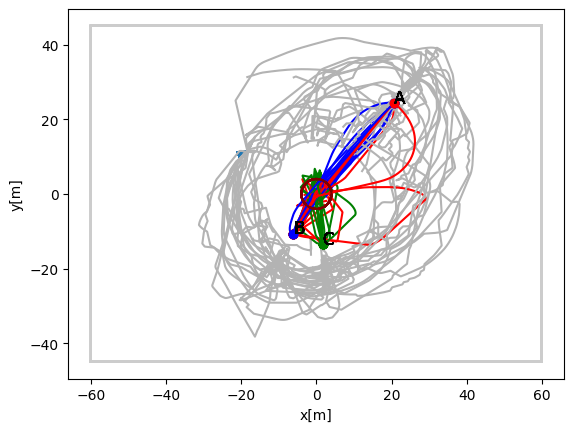

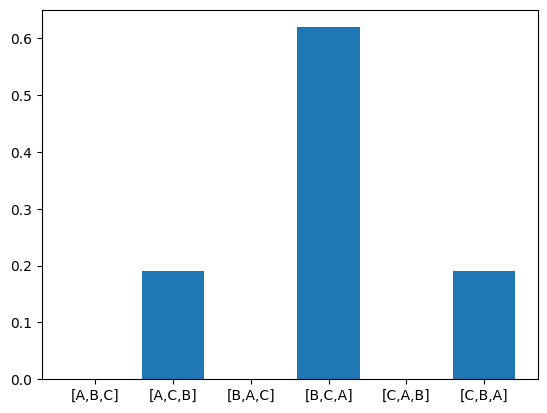

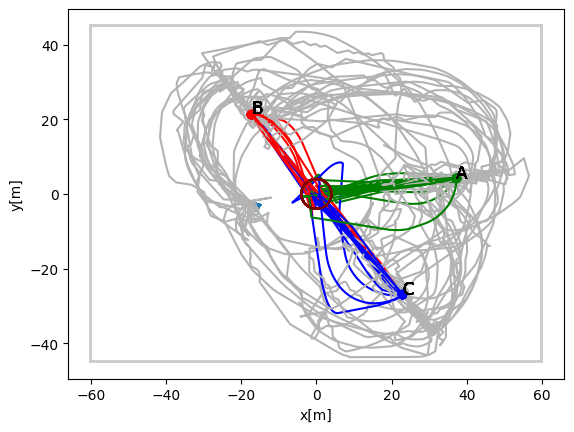

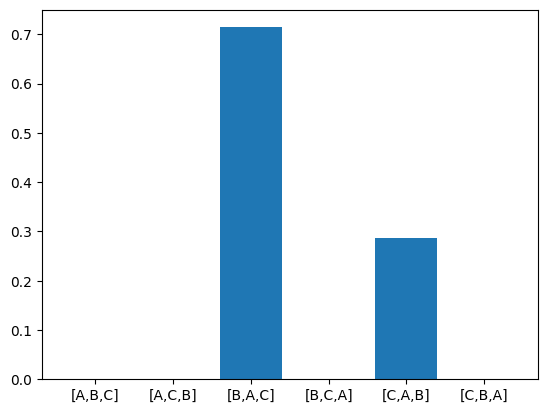

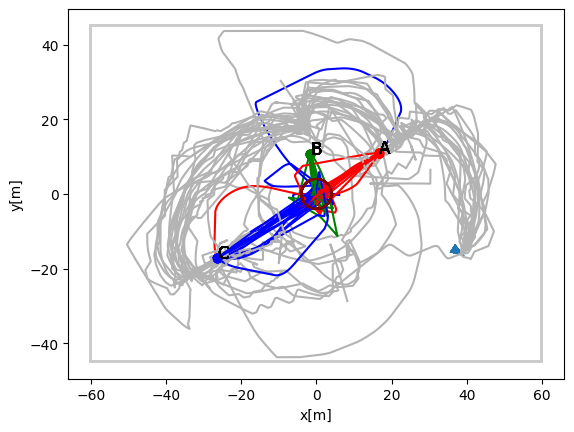

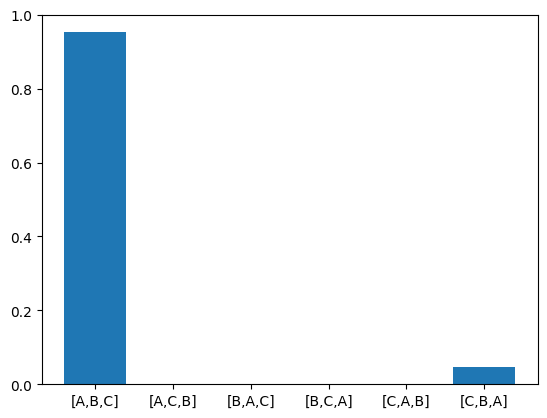

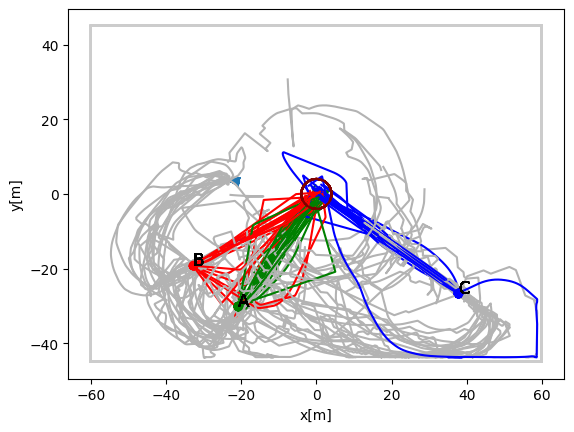

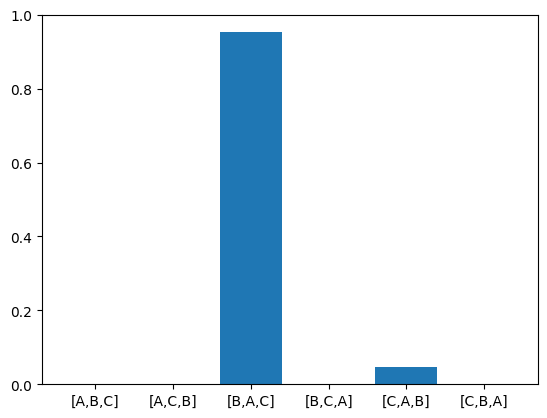

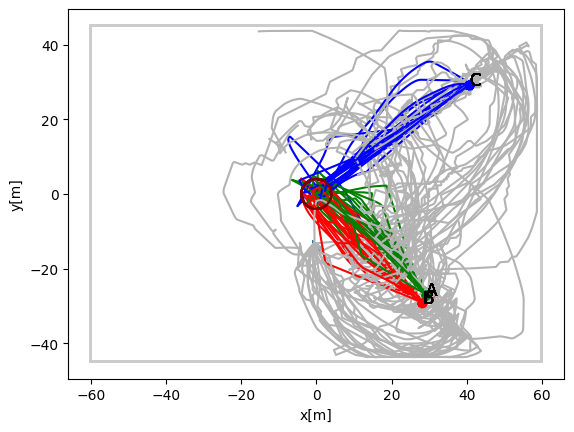

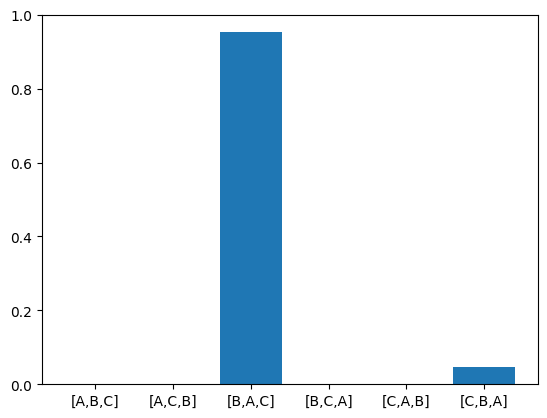

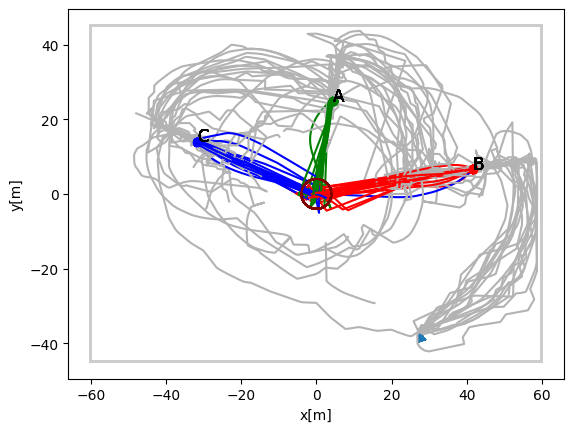

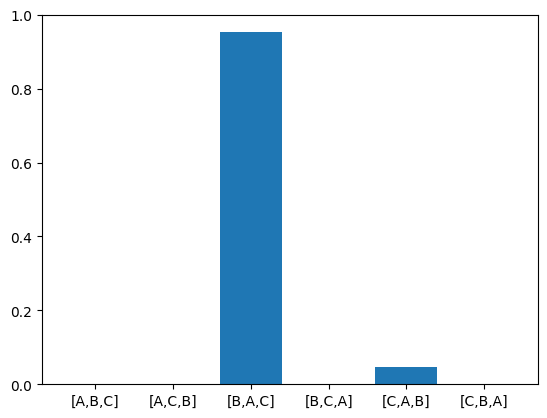

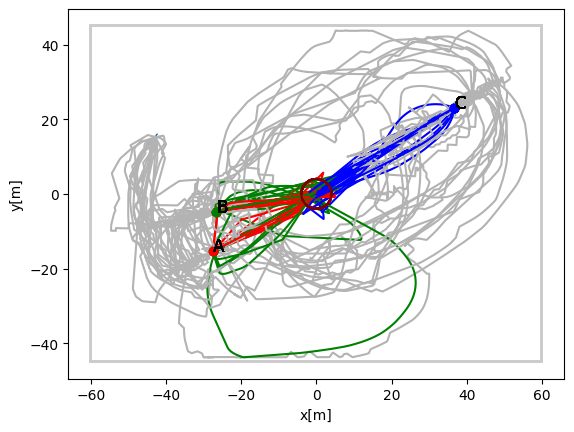

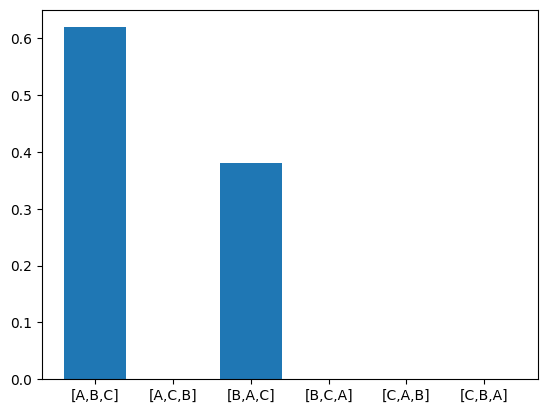

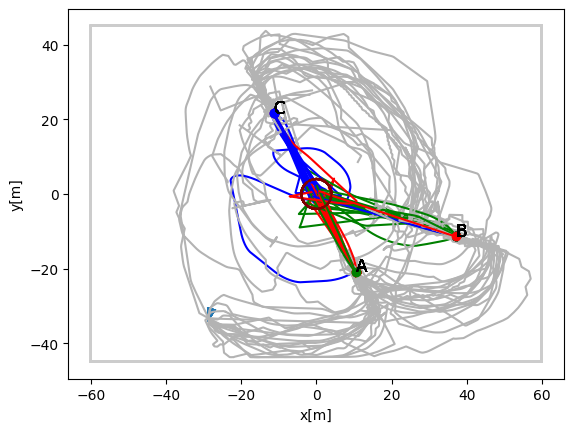

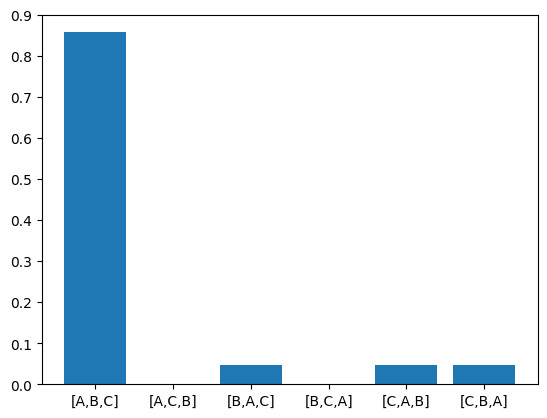

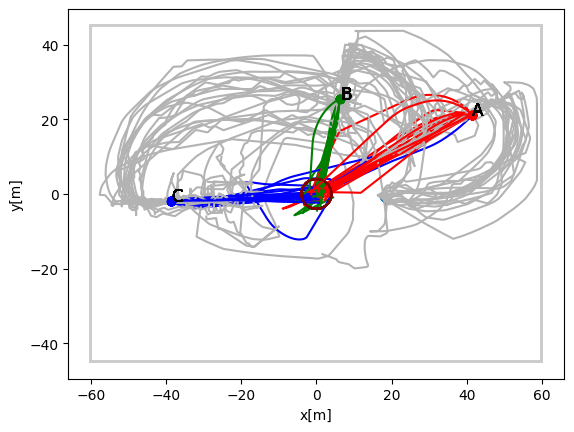

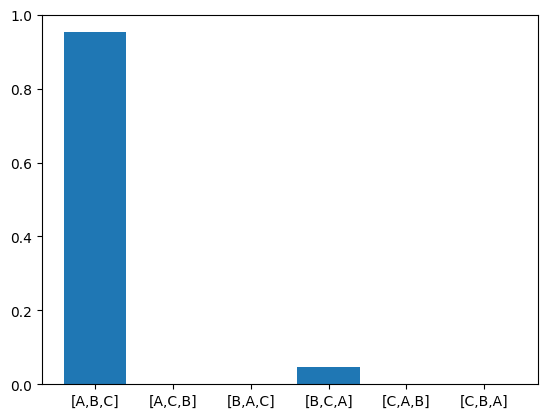

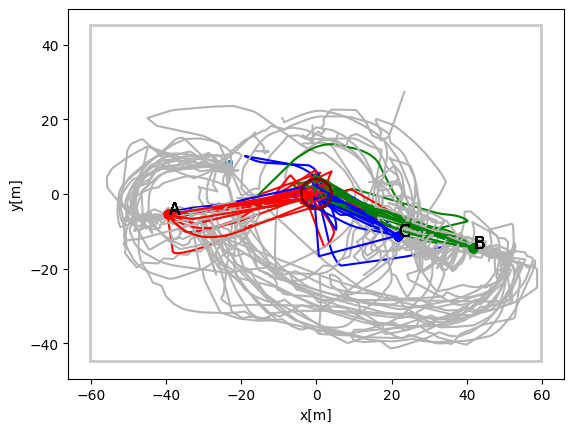

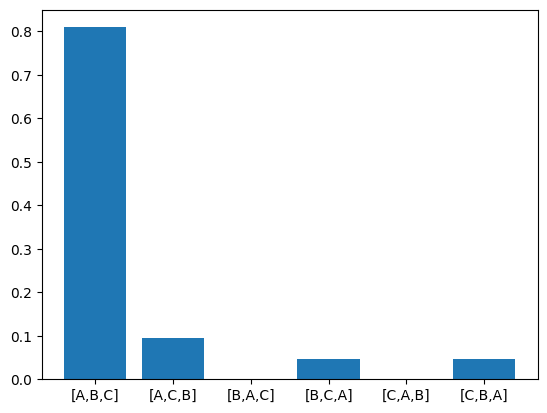

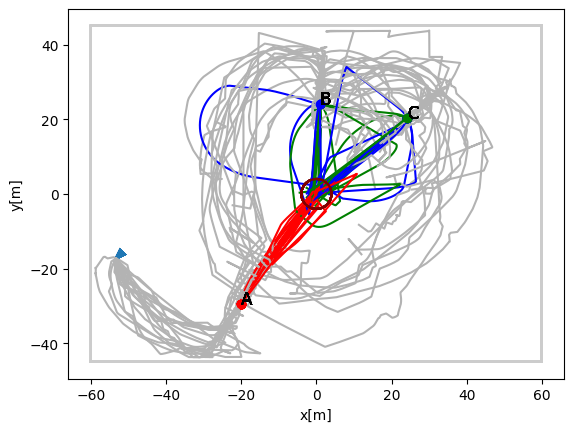

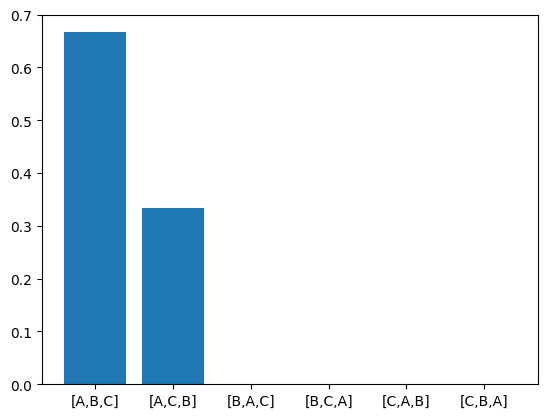

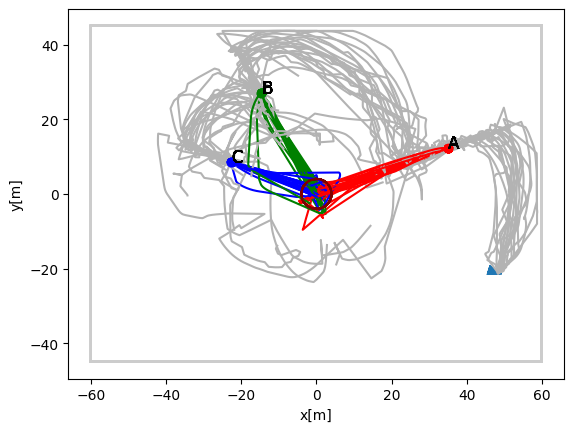

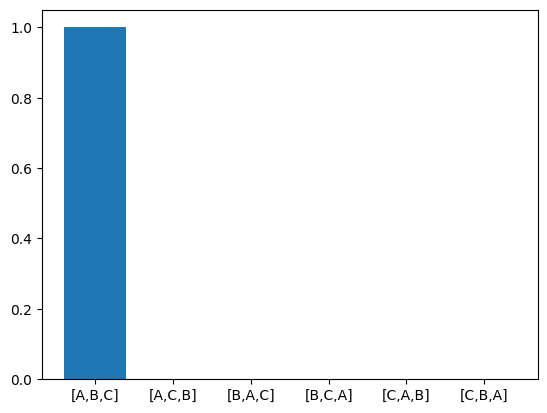

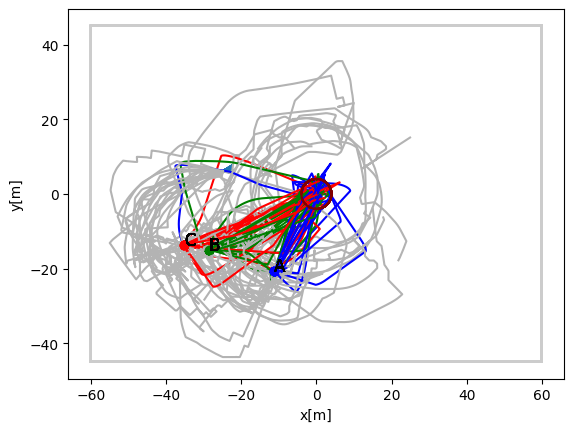

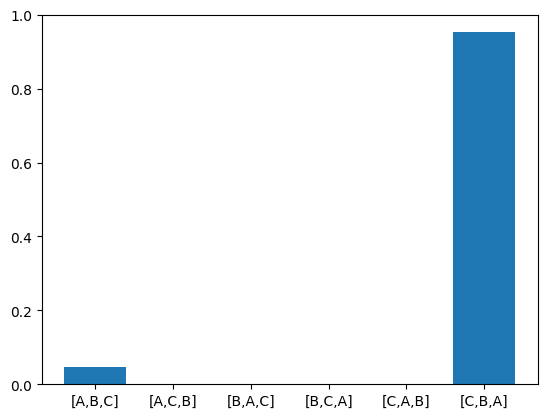

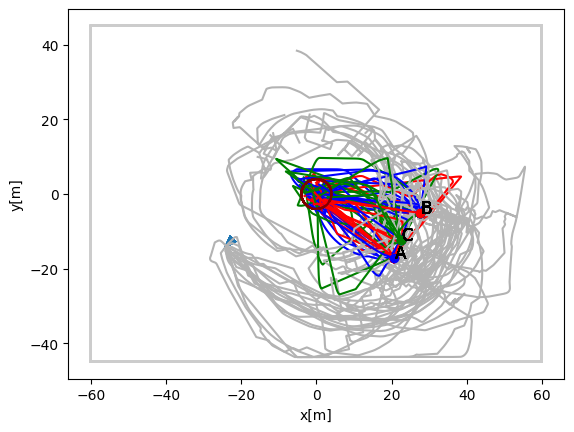

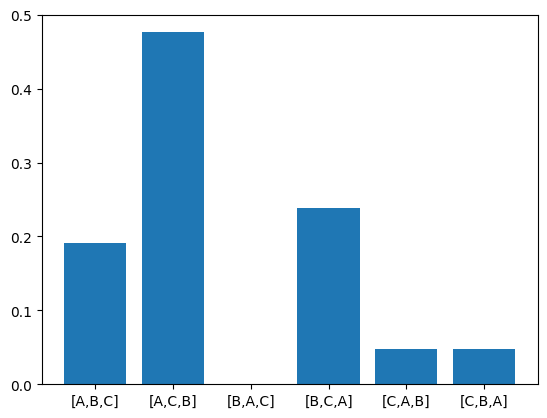

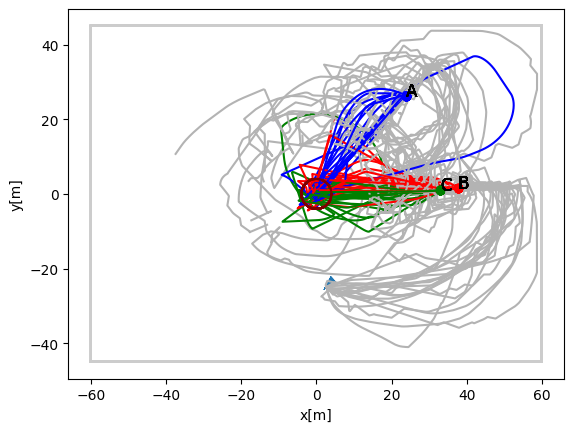

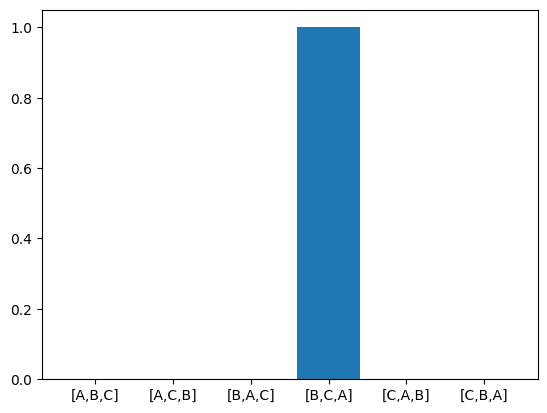

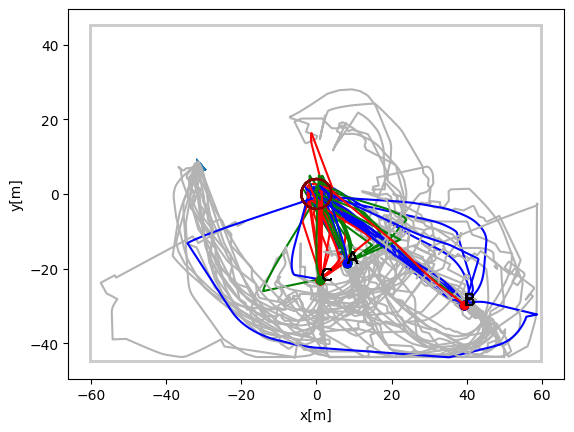

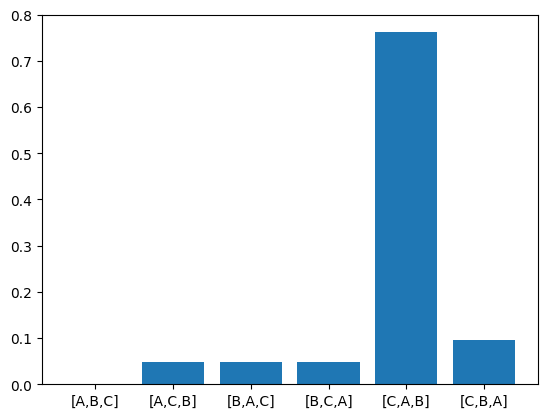

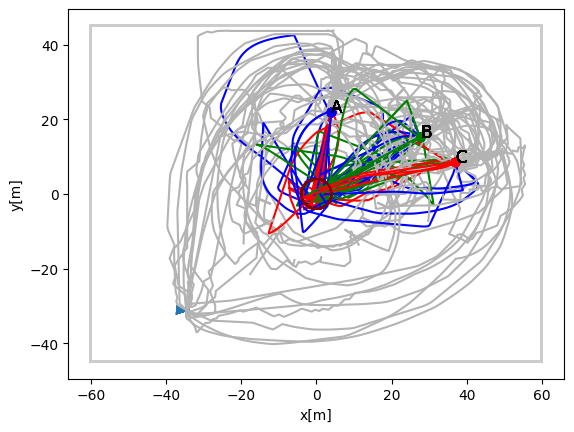

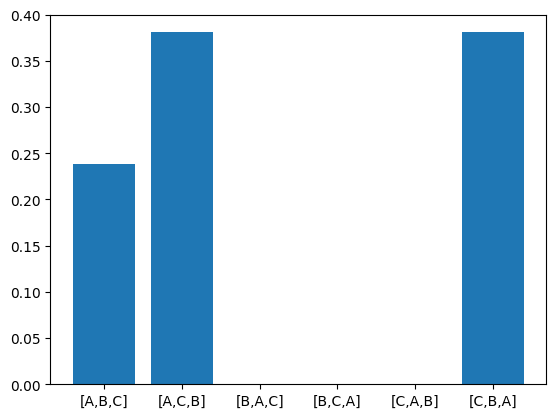

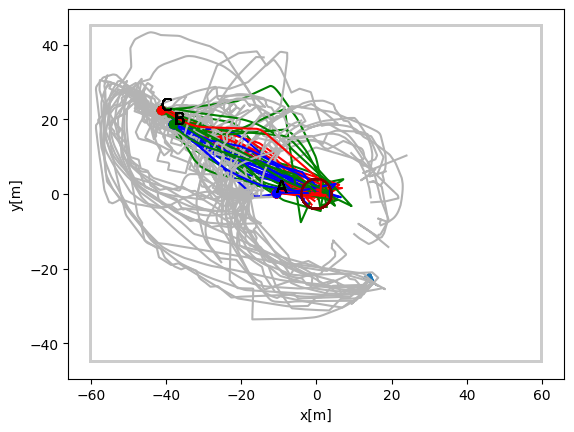

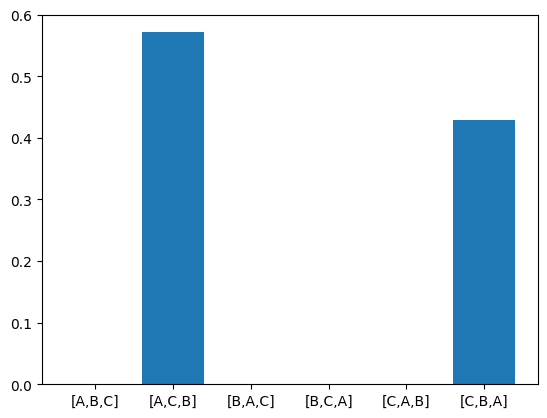

<Figure size 640x480 with 0 Axes>

In [12]:
# Do Trajectory PLots
tCount = 0
for trial in range(firstTrial,lastTrial):
    trial_ID = "{:02}".format(trial)
    
    filePaths = [path for path in Path(dataDir).rglob('*trialIdentifier'+trial_ID+'*')]
    initCondsData = pd.read_csv(filePaths[0]) # I say 0 but any will do as it's all based in init conds

    for filePath in filePaths:
        trialData = pd.read_csv(filePath)
        observedTargetOrdering = np.argsort([np.where(trialData.t0run)[0][0], np.where(trialData.t1run)[0][0], np.where(trialData.t2run)[0][0]])
        plotter(trialData, observedTargetOrdering, colors)
    
    #plt.title("Trial ID:"+trial_ID+", Max score is "+Keymax+" score: "+str(trial_specific_score[Keymax]))
    #plt.title("Trial ID:"+trial_ID)
    plt.xlabel("x[m]")
    plt.ylabel("y[m]")
    plt.figure()

    x_labels = ["[A,B,C]", "[A,C,B]", "[B,A,C]", "[B,C,A]", "[C,A,B]", "[C,B,A]"]
    values = targetPermutationOrderCount[tCount,:] / 21
    
    plt.bar([1,2,3,4,5,6], values)
    plt.xticks([1,2,3,4,5,6],x_labels)
    plt.figure()

    tCount = tCount + 1